# Our methods uncover more information about network topology than neuroanatomical metrics

How do we know that our methods add anything of value to connectomics?
One way is to compare against prevailing methods.

One popular connectomics method is to compare brain regions across subjects
using anatomnical measurements from those regions (e.g., region volume).
We ask: *does this approach capture the same information about connectivity as `omni`?*

We do this information theoretic comparison using a conditional indendence test.

This notebook recreates Figure 6 from *Multiscale Comparative Connectomics*.
![Fig6](figures/6_causal.jpg)

In [1]:
%load_ext nb_black
%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [2]:
from itertools import product

import numpy as np
import pandas as pd
from graspologic.datasets import load_mice
from graspologic.embed import OmnibusEmbed
from statsmodels.stats.multitest import multipletests

<IPython.core.display.Javascript object>

In [3]:
# Load the full mouse dataset
mice = load_mice()

<IPython.core.display.Javascript object>

In [4]:
# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Jointly embed graphs using OMNI
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)
omni_embedding = omni_embedding.reshape(-1, omni_embedding.shape[-1])
print(f"Omnibus embedding shape is {omni_embedding.shape}")

# Convert array to a dataframe
omni_embedding = pd.DataFrame(
    omni_embedding, columns=[f"omni_{i + 1}" for i in range(omni_embedding.shape[-1])]
).astype(np.float64)
omni_embedding.head()

Omnibus embedding shape is (10624, 5)


,omni_1,omni_2,omni_3,omni_4,omni_5
0,12.730154,-5.338366,-2.503565,14.369667,4.277382
1,9.080038,-3.107737,-0.569771,14.679973,2.005405
2,3.491072,-2.343092,-5.636349,11.416039,-0.373804
3,0.761835,-0.652198,-1.929811,3.537828,-0.247422
4,9.124708,-2.755428,-2.402753,17.376237,0.947563


<IPython.core.display.Javascript object>

In [5]:
# Construct identifiers for each embedded vertex
left = mice.atlas["ROI"].unique()
right = left + 1000
rois = np.append(left, right)

participants = mice.participants["participant_id"]
participants = participants.apply(lambda x: x.split("-")[1])

identifiers = np.array(list(product(participants, rois))).reshape(-1, 2)
identifiers = pd.DataFrame(identifiers, columns=["participant_id", "ROI"])
identifiers["ROI"] = identifiers["ROI"].astype(np.int64)
identifiers["genotype"] = identifiers["participant_id"].apply(
    lambda i: mice.participants.query(f"participant_id == 'sub-{i}'")[
        "genotype"
    ].values[0]
)

omni_embedding = pd.concat([omni_embedding, identifiers], axis=1)
omni_embedding.head()

,omni_1,omni_2,omni_3,omni_4,omni_5,participant_id,ROI,genotype
0,12.730154,-5.338366,-2.503565,14.369667,4.277382,54776,1,DBA2
1,9.080038,-3.107737,-0.569771,14.679973,2.005405,54776,2,DBA2
2,3.491072,-2.343092,-5.636349,11.416039,-0.373804,54776,3,DBA2
3,0.761835,-0.652198,-1.929811,3.537828,-0.247422,54776,4,DBA2
4,9.124708,-2.755428,-2.402753,17.376237,0.947563,54776,5,DBA2


<IPython.core.display.Javascript object>

In [6]:
anatomy = mice.features[["volume_mm3", "adc", "fa", "rd", "participant_id", "ROI"]]
anatomy.head()

,volume_mm3,adc,fa,rd,participant_id,ROI
0,2106.923246,0.000384,0.274220,0.000311,54811,0
1,1.169498,0.000317,0.195003,0.000286,54811,1
2,0.788778,0.000324,0.173186,0.000297,54811,2
3,0.433482,0.000337,0.178772,0.000310,54811,3
4,0.207218,0.000332,0.233240,0.000295,54811,4


<IPython.core.display.Javascript object>

In [7]:
df = pd.merge(anatomy, omni_embedding, on=["participant_id", "ROI"])
columns = [
    "genotype",
    "participant_id",
    "ROI",
    "volume_mm3",
    "adc",
    "fa",
    "rd",
    "omni_1",
    "omni_2",
    "omni_3",
    "omni_4",
    "omni_5",
]
df = df[columns]
assert df.shape[0] == anatomy.shape[0] - 32 == omni_embedding.shape[0]
df.head()

,genotype,participant_id,ROI,volume_mm3,adc,fa,rd,omni_1,omni_2,omni_3,omni_4,omni_5
0,BTBR,54811,1,1.169498,0.000317,0.195003,0.000286,15.849042,-5.451059,7.833718,20.197061,6.971619
1,BTBR,54811,2,0.788778,0.000324,0.173186,0.000297,12.256862,-4.184300,-0.021644,20.847276,1.763333
2,BTBR,54811,3,0.433482,0.000337,0.178772,0.000310,3.871277,-2.526653,-5.081744,11.851098,-0.241778
3,BTBR,54811,4,0.207218,0.000332,0.233240,0.000295,1.579193,-1.144775,-2.968037,5.453984,-0.438220
4,BTBR,54811,5,0.856119,0.000320,0.182581,0.000292,17.189417,-3.108872,2.187134,21.089432,2.593552


<IPython.core.display.Javascript object>

In [8]:
%%R -i df

suppressPackageStartupMessages(library(cdcsis))
suppressPackageStartupMessages(library(data.table))
library(mltools)
library(future)
library(future.apply)

df$genotype <- as.factor(df$genotype)

<IPython.core.display.Javascript object>

In [9]:
%%R

pdcov.roi <- function(parameters, df, outfile) {
  
  roi <- as.integer(parameters[1])
  metric <- parameters[2]
  
  sub.df <- df[which(df$ROI == roi), ]
  X <- sub.df["genotype"]
  X <- one_hot(as.data.table(X))
  Y <- sub.df[c("omni_1", "omni_2", "omni_3", "omni_4", "omni_5")]
  Z <- sub.df[c(metric)]
  fit <- cdcov.test(X, Y, Z, num.bootstrap = 1000000)
  
  print(paste(roi, metric, fit$p.value))
  
  results <- paste(c(roi, metric, as.numeric(fit$statistic), fit$p.value), collapse=",")
  write(results, outfile, append=TRUE)
  
}

<IPython.core.display.Javascript object>

In [10]:
%%R

# Conditional independence test for the top 5 most significant vertices by MANOVA o Omni.
metrics <- c("volume_mm3", "adc", "fa", "rd")
rois <- c(seq(166), seq(166) + 1000)
parameter_space <- expand.grid(rois, metrics)

# Get p.value and test statistic for each node
outfile <- "../results/pdcov_omni_given_metric.csv"
header <- paste(c("roi", "metric", "statistic", "pvalue"), collapse=",")
write(header, file=outfile, append=TRUE)
future_apply(parameter_space, 1, FUN=function(parameters) {pdcov.roi(parameters, df, outfile)})

In [11]:
def relabel_roi(x):
    if x > 166:
        x += 1000 - 166
    return x


df = pd.read_csv("../results/pdcov_omni_given_metric.csv")
_, holm_pvalue, _, _ = multipletests(df["pvalue"], method="holm")
df["holm_pvalue"] = holm_pvalue
df = df.pivot(index="roi", columns="metric")["holm_pvalue"]

# Reindex by MANOVA rankings
manova_rankings = pd.read_csv("../results/signal_vertices.csv").ROI
manova_rankings = manova_rankings.apply(relabel_roi)
df = df.reindex(manova_rankings)
df.columns = ["Volume", "ADC", "FA", "RD"]

top_20_vertices = df.iloc[:20, :].T.values
top_20_vertices = np.log10(top_20_vertices)

df.head()

,Volume,ADC,FA,RD
ROI,,,,
121,0.001328,0.001328,0.001328,0.001328
1121,0.001328,0.001328,0.001328,0.001328
120,0.024111,0.028690,0.024111,0.036176
20,0.002934,0.003120,0.002934,0.019344
1085,0.001328,0.001328,0.001328,0.001328


<IPython.core.display.Javascript object>

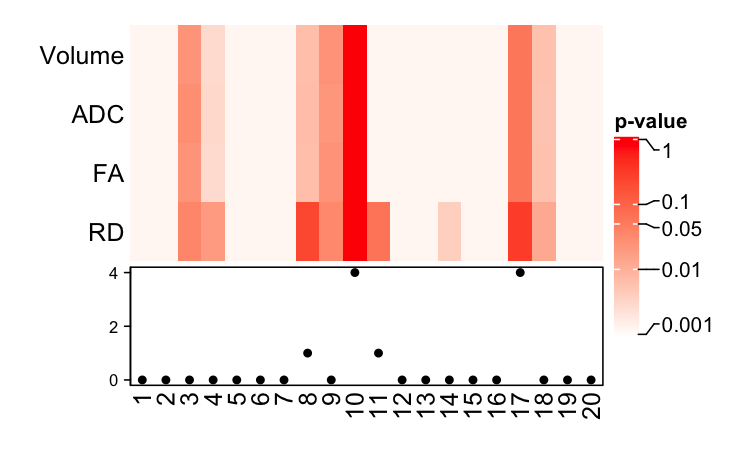

<IPython.core.display.Javascript object>

In [12]:
%%R -i top_20_vertices -w 5 -h 3 --units in -r 150

suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))

pval <- as.matrix(top_20_vertices)
rows <- c("Volume", "ADC", "FA", "RD")
rownames(pval) <- rows
colnames(pval) <- c(1:20)

ha1 = HeatmapAnnotation(
  foo = anno_points(
    apply(pval > log10(0.05), 2, sum),
    height = unit(2, "cm")
  ),
  show_annotation_name = FALSE
)

col <- colorRamp2(c(0, -3), c("red", "white"))
ht <- Heatmap(
  pval,
  name = "p-value",
  col = col,
  cluster_columns = FALSE, cluster_column_slices = FALSE,
  cluster_rows = FALSE, cluster_row_slices = FALSE, show_row_names = TRUE, row_title = NULL, row_names_side = "left",
  width = unit(8, "cm"), height = unit(4, "cm"),
  heatmap_legend_param = list(at = log10(c(1, 0.1, 0.05, 0.01, 0.001)), labels = c(1, 0.1, 0.05, 0.01, 0.001), legend_height = unit(3.4, "cm")),
  bottom_annotation = ha1,
)
draw(ht)

leg = Legend(
  col, 
  title = "p-value", 
  at = log10(c(1, 0.1, 0.05, 0.01, 0.001)),
  labels = c(1, 0.1, 0.05, 0.01, 0.001),
  legend_height = unit(10, "cm"),
  direction = "horizontal", title_position = "lefttop"
)

In [13]:
# Calculate the number of confounders for each vertex
df["sum"] = (df > 0.05).sum(axis=1)

# How many vertices have at least 1 cofounder?
ans = np.sum(df["sum"] > 0)
print(f"{ans} vertices have at least 1 anatomical confounder")

# How many vertices have all 4 anatomical features as confounders?
ans = np.sum(df["sum"] == 4)
print(f"{ans} vertices have 4 anatomical confounders")

# How many vertices with 4 confounders are in the top 100 signal vertices?
ans = np.sum(df.iloc[:100]["sum"] == 4)
print(
    f"{ans} vertices with 4 anatomical confounders are in the top 100 signal vertices"
)

40 vertices have at least 1 anatomical confounder
28 vertices have 4 anatomical confounders
7 vertices with 4 anatomical confounders are in the top 100 signal vertices


<IPython.core.display.Javascript object>